In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torchvision import datasets, transforms,models

In [0]:
from glob import glob

In [24]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/Intro to Deep Learning with PyTorch/cats_and_dogs_filtered/'

In [0]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

In [27]:
num_dogs_train = len(glob(train_dir + '/dogs/*.jp*g'))
num_cats_train = len(glob(train_dir + '/cats/*.jp*g'))

num_dogs_validation = len(glob(validation_dir + '/dogs/*.jp*g'))
num_cats_validation = len(glob(validation_dir + '/cats/*.jp*g'))

total_train = len(glob(train_dir + '/*/*.jp*g'))
total_validation = len(glob(validation_dir + '/*/*.jp*g'))

print('total training dog images:', num_dogs_train)
print('total training cat images:', num_cats_train)
print("")
print('total validation dog images:', num_dogs_validation)
print('total validation cat images:', num_cats_validation)
print("")
print("Total training images:", total_train)
print("Total validation images:", total_validation)

# useful for getting number of classes
folders = glob(train_dir + '/*')

total training dog images: 1000
total training cat images: 1000

total validation dog images: 500
total validation cat images: 500

Total training images: 2000
Total validation images: 1000


### Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

We'll also need to convert the images to PyTorch tensors with transforms.ToTensor(). Typically you'll combine these transforms into a pipeline with transforms.Compose(), which accepts a list of transforms and runs them in sequence.

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are [0.485, 0.456, 0.406] and the standard deviations are [0.229, 0.224, 0.225].

In [0]:
train_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],          # This is equivalent of preprocessing_function=preprocess_input in Keras
                                                            [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

### Loading Images

The easiest way to load image data is with datasets.ImageFolder from torchvision

In [0]:
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(validation_dir, transform=validation_transforms)

### Data Loaders

With the ImageFolder loaded, you have to pass it to a DataLoader. The DataLoader takes a dataset (such as you would get from ImageFolder) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

In [0]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=100)

Here dataloader is a generator. To get data out of it, you need to loop through it or convert it to an iterator and call next().

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


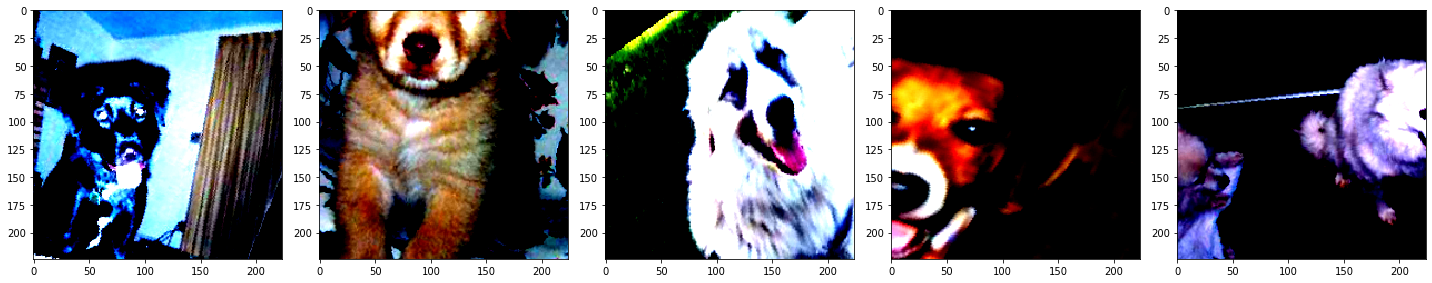

In [31]:
# Run this to test your data loader
sample_training_images, labels = next(iter(trainloader))

def plotImages(images_arr):
  # print(images_arr.shape)      torch.Size([5, 3, 224, 224])
  fig, axes = plt.subplots(1, 5, figsize=(20,5))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    img=img.permute(1,2,0)    # also we can use img=img.view(img.shape[1], img.shape[2], img.shape[0]). This is done to reshape from (C, H, W) to (H, W, C)
    # print(img.shape)        # torch.Size([224, 224, 3])
    ax.imshow(img)
  plt.tight_layout()
  plt.show()
    
plotImages(sample_training_images[:5])       # Plot images 0-4

In [32]:
# Use GPU if it's available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvcc --version    # Google Colab has Cuda pre-installed

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [33]:
res = models.resnet50(pretrained=True)
res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer (classifier): Linear(in_features=2048, out_features=1000). This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace only the classifier, as the features will work perfectly on their own.

In [34]:
# Freeze parameters so we don't backprop through them
for param in res.parameters():
    param.requires_grad = False
    
# classes = trainloader.dataset.classes
# num_classes = len(classes)
# print('Using {:d} classes: {}'.format(num_classes, classes))      # Using 2 classes: ['cats', 'dogs']

res.fc = nn.Sequential(nn.Linear(2048, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, len(folders)))
res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(res.fc.parameters(), lr=0.003)

In [0]:
def train(model, loss, optimizer, inputs, labels):
  # set the model to training mode
  # because dropout has 2 different modes!
  # we only perform dropout in train mode & not test mode
  model.train()

  inputs = Variable(inputs, requires_grad=False)
  labels = Variable(labels, requires_grad=False)

  optimizer.zero_grad()

  # get output from the model, given the inputs
  logps = model.forward(inputs)

  # get loss for the predicted output
  cost = loss.forward(logps, labels)

  # get gradients w.r.t to parameters
  cost.backward()

  # update parameters
  optimizer.step()

  return cost.item()

In [0]:
def test(model, loss, inputs, labels):
  model.eval()

  inputs = Variable(inputs, requires_grad=False)
  labels = Variable(labels, requires_grad=False)

  logps = model.forward(inputs)
  cost = loss.forward(logps, labels)

  return cost.item()

In [0]:
def predict(model, inputs):
  model.eval()
      
  inputs = Variable(inputs, requires_grad=False)
      
  logps = model.forward(inputs)
  return logps.data.numpy().argmax(axis=1)

In [0]:
j = 0

train_costs = []
test_costs = []
train_accuracies = []
test_accuracies = []

for inputs, labels in trainloader:
  j += 1
  train_c=train(res, criterion, optimizer, inputs, labels)
  train_costs.append(train_c)

  p_train = predict(res, inputs)
  acc_train = np.mean(p_train == labels.numpy())
  train_accuracies.append(acc_train)

  if j % 5 == 0:
    for inputs_t, labels_t in testloader:
      test_c=test(res, criterion, inputs_t, labels_t)
      test_costs.append(test_c)

      p_test = predict(res, inputs_t)
      acc_test = np.mean(p_test == labels_t.numpy())
      test_accuracies.append(acc_test)

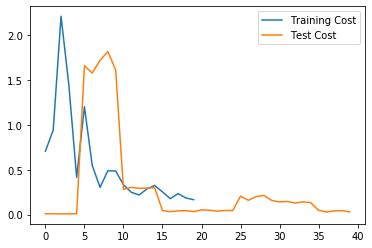

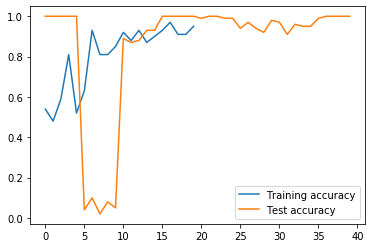

In [40]:
plt.plot(train_costs, label='Training Cost')
plt.plot(test_costs, label='Test Cost')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training accuracy')
plt.plot(test_accuracies, label='Test accuracy')
plt.legend()
plt.show()